# Introduction





## Summary

Parkinson's disease is a progressive neurological disorder that affects movement and motor skills. It results from the deterioration of dopamine-producing neurons in the brain, leading to symptoms such as tremors, stiffness, and difficulty in walking. Early diagnosis and intervention are crucial for managing the disease and improving the quality of life for affected individuals. However, accurately diagnosing Parkinson's can be challenging due to its similarity with other movement disorders and the lack of definitive tests.
The primary goal of this project is to leverage the Parkinson's dataset and machine learning techniques to develop a predictive model that can accurately identify individuals with Parkinson's disease based on various biomedical voice measurements. The dataset contains a set of quantitative features extracted from voice recordings of both healthy individuals and those with Parkinson's.

## Importing Libraries


Let's start by importing the libraries we will be using

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import seaborn as sns

# Machine learning models and utilities
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Data visualization
import matplotlib.pyplot as plt

# Data Description and Exploratory Analysis

The Parkinson's dataset consists of a range of biomedical voice measurements from 195 people, out of which 48 have Parkinson's disease. The dataset contains 195 records, with each record corresponding to a voice recording of an individual. Each record consists of 24 attributes, where 22 of these are quantitative voice features, one attribute represents the subject's ID, and the final attribute is a binary target variable indicating the presence of Parkinson's disease (1 for positive and 0 for negative).

Attribute Information (Name = Description):
1. MDVP:Fo(Hz) = Average vocal fundamental frequency
2. MDVP:Fhi(Hz) = Maximum vocal fundamental frequency
3. MDVP:Flo(Hz) = Minimum vocal fundamental frequency
4. MDVP:Jitter(%) = measures of variation in fundamental frequency
5. MDVP:Jitter(Abs) = measures of variation in fundamental frequency
6. MDVP:RAP = measures of variation in fundamental frequency
7. MDVP:PPQ = measures of variation in fundamental frequency
8. Jitter:DDP = measures of variation in fundamental frequency
9. MDVP:Shimmer = measures of variation in amplitude
10. MDVP:Shimmer(dB) = measures of variation in amplitude
11. Shimmer:APQ3 = measures of variation in amplitude
12. Shimmer:APQ5 = measures of variation in amplitude
13. MDVP:APQ = measures of variation in amplitude
14. Shimmer:DDA = measures of variation in amplitude
15. NHR  = measures of ratio of noise to tonal components in the voice
16. HNR  = measures of ratio of noise to tonal components in the voice
17. Target = Health status of the subject: 1 - Parkinson's, 0 - healthy
18. RPDE  = nonlinear dynamical complexity measures
19. D2  = nonlinear dynamical complexity measures
20. DFA	 = Signal fractal scaling exponent
21. spread1 = nonlinear measures of fundamental frequency variation
22. spread2	 = nonlinear measures of fundamental frequency variation
23. PPE = nonlinear measures of fundamental frequency variation

The primary goal is to discriminate between healthy individuals and those with Parkinson's disease based on these voice measurements.

## Data Preprocessing



I added column names to the csv file to correlate with the columns of data. I also used the sklearn module to standardscale the data to standardise the data.

In [ ]:
#@title

column_names = [
    "MDVP:Fo(Hz)", "MDVP:Fhi(Hz)", "MDVP:Flo(Hz)", "MDVP:Jitter(%)", "MDVP:Jitter(Abs)", "MDVP:RAP",
    "MDVP:PPQ", "Jitter:DDP", "MDVP:Shimmer", "MDVP:Shimmer(dB)", "Shimmer:APQ3", "Shimmer:APQ5",
    "MDVP:APQ", "Shimmer:DDA", "NHR", "HNR", "Target", "RPDE", "D2", "DFA", "spread1", "spread2", "PPE"
]

# Load the dataset without headers
data = pd.read_csv("parkinsons.csv", header=None)

# Set the column names
data.columns = column_names

# Separate the features and the target variable
X = data.drop("Target", axis=1)
y = data["Target"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Principal Component Analysis (PCA)
Removing the dimensionality of the dataset to visualise the data in a lower dimensional space. This will help me identify any potential clusters or patterns in the data that may be potentially useful for future classification.

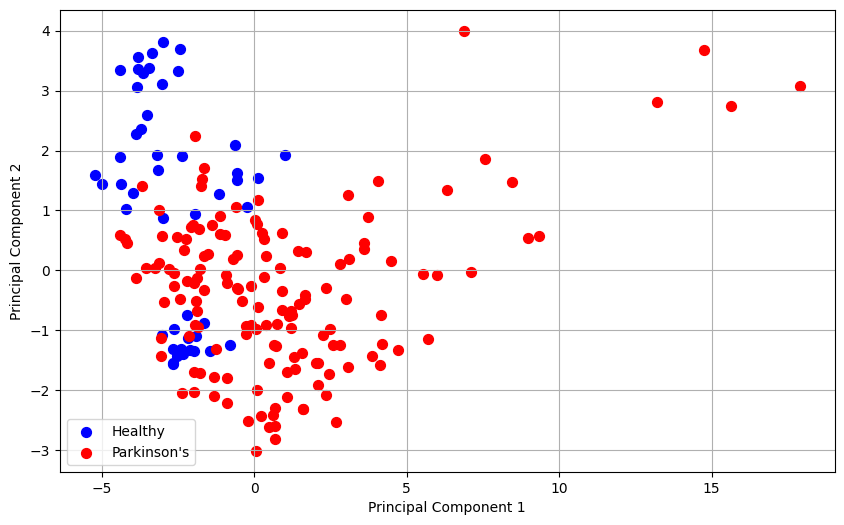

In [ ]:
#@title
# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=["Principal Component 1", "Principal Component 2"])

# Add the target variable to the DataFrame
principal_df["Target"] = y

# Visualize the principal components
plt.figure(figsize=(10, 6))
colors = ["blue", "red"]
targets = [0, 1]
labels = ["Healthy", "Parkinson's"]

for target, color, label in zip(targets, colors, labels):
    indices_to_keep = principal_df["Target"] == target
    plt.scatter(principal_df.loc[indices_to_keep, "Principal Component 1"],
                principal_df.loc[indices_to_keep, "Principal Component 2"],
                c=color, s=50, label=label)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

The clusters and separations here indicate that the principal components have captured some meaningful structure in this dataset. The distribution suggests that there may be some separation between the two classes (healthy/Parkinson's).

## Correlation Matrix
Creating a correlation matrix to explore the relationships between the different attributes may help identify any strong correlations between variables that may impact the model's performance.

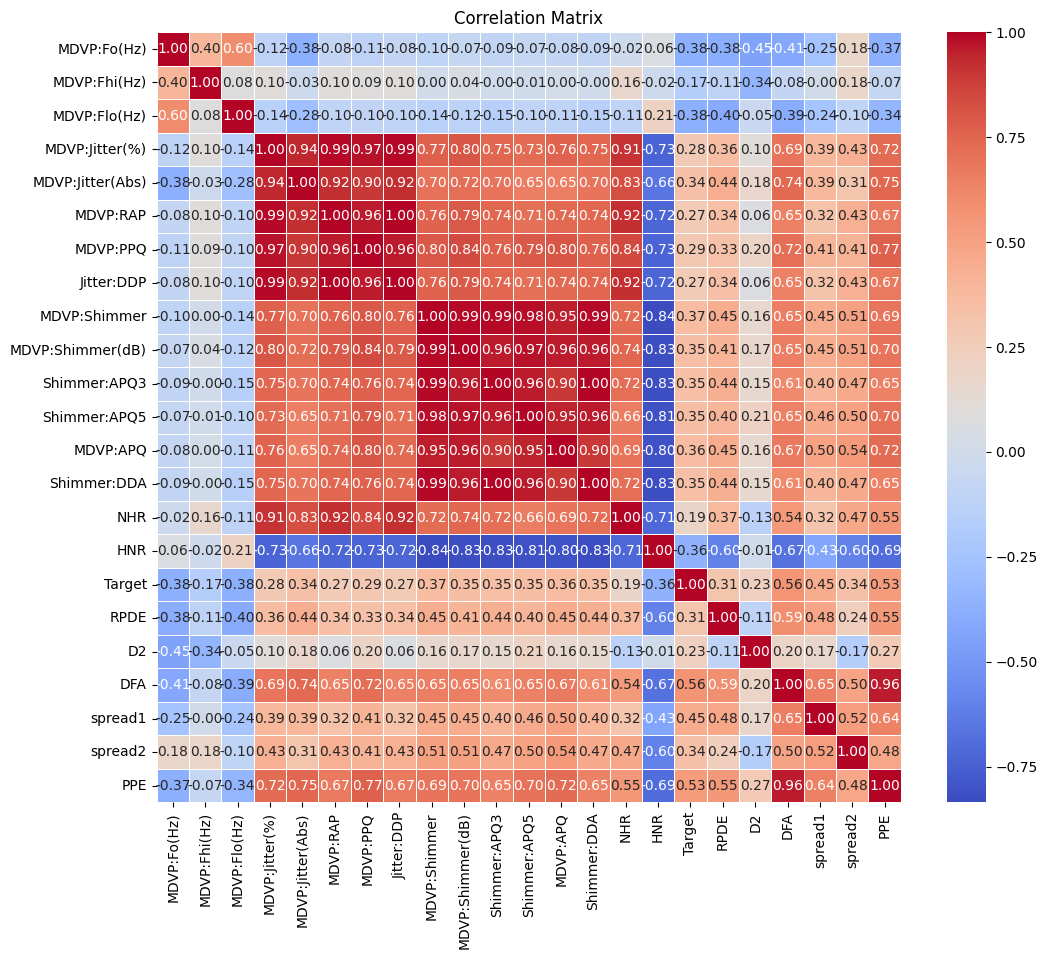

In [ ]:
#@title
# Computing the correlation matrix
corr_matrix = data.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

I can see that the DFA attribute has the strongest positive correlation with the target variable, while MDVP:Fo(Hz) and MDVP:Flo(Hz) have the strongest negative correlation.

# Building the model



To build an effective machine learning model, I can use the information collected from the PCA analysis to select suitable feature extraction and dimensionality reduction techniques, as well as choose an appropriate classifier. The PCA plot also highlights the importance of considering the full distribution of data points and potential outliers when training and evaluating a model.

## RandomForestClassifier

RandomForestClassifier is a useful machine learning method that works well with many features, and it doesn't overfit the data easily. After using PCA, the dataset has fewer dimensions, but the new features might be harder to understand since they are combinations of the original ones. RandomForestClassifier is a good choice in this situation because it combines the results of multiple decision trees, making it less dependent on any single feature. This makes it a suitable classifier to use after reducing the number of dimensions with PCA.


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        19
           1       0.92      0.92      0.92        50

    accuracy                           0.88        69
   macro avg       0.85      0.85      0.85        69
weighted avg       0.88      0.88      0.88        69


Accuracy Score:
0.8840579710144928


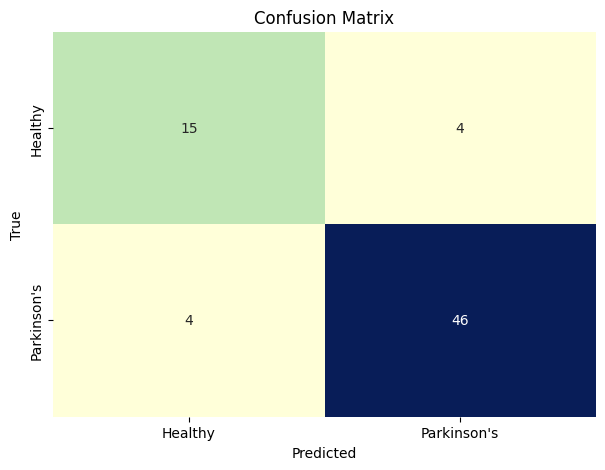

In [ ]:
#@title
# Applying feature extraction or dimensionality reduction techniques (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.35, random_state=12)

# Choosing and train an appropriate classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=6)
classifier.fit(X_train, y_train)

# Evaluating the model's performance using cross-validation or a hold-out test set
y_pred = classifier.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False, xticklabels=["Healthy", "Parkinson's"], yticklabels=["Healthy", "Parkinson's"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

This means, out of 69 predictions:
*   15 true negatives: correctly predicted healthy subjects (class 0)
*   46 true positives: correctly predicted subjects with Parkinson's (class 1)
*  4 false positives: healthy subjects misclassified as having Parkinson's
*   4 false negatives: subjects with Parkinson's misclassified as healthy

The classification report provides several different metrics for each class:
*   Precision = proportion of true positive predictions among all positive predictions
*   Recall = proportion of true positive predictions amongst all actual positive instances
*   F1-score = metric that balances precision and recall

Analysing this, I can see that the model has a higher prediction and recall score for class 1 (those with Parkinson's) than class 0 (healthy individuals). Furthermore, the overall accuracy is 0.88405 which indicates that the model can correctly predict health statuses in ~88% of cases.







## K-Nearest-Neighbours Classifier

I chose KNN because it can capture local patterns in the data and make predictions based on the similarity of data points. This may be particularly useful in identifying the presence of Parkinson's disease, where a patient's voice characteristics may have subtle differences compared to healthy individuals.

Best Hyperparameters:
{'classifier__n_neighbors': 3, 'classifier__weights': 'uniform', 'feature_selection__k': 20}

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.96      0.93      0.94        54

    accuracy                           0.91        69
   macro avg       0.86      0.90      0.88        69
weighted avg       0.92      0.91      0.91        69


Accuracy Score:
0.9130434782608695


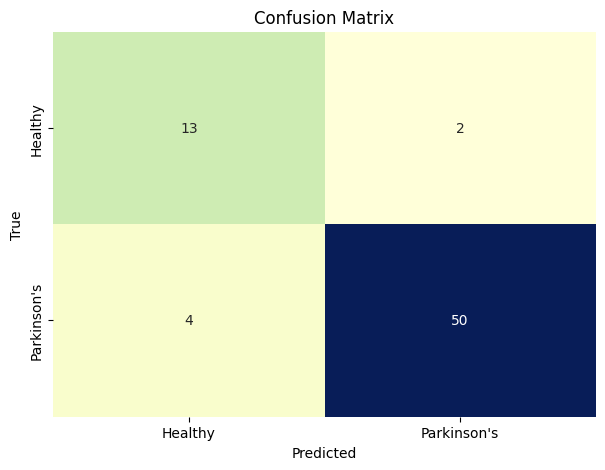

In [ ]:
#@title
# Load the dataset without headers
data = pd.read_csv("parkinsons.csv", header=None)

# Set the column names
data.columns = column_names

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=6)

# Create a pipeline with feature selection, scaling, and classification
pipe = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

# Define the hyperparameters and values to search
param_grid = {
    'feature_selection__k': [5, 10, 15, 20],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Evaluate the model's performance using the hold-out test set
y_pred = grid_search.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Plotting the heatmap
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False, xticklabels=["Healthy", "Parkinson's"], yticklabels=["Healthy", "Parkinson's"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Discussing Results



Top 10 most important features:
DFA                 0.564838
PPE                 0.531039
spread1             0.454842
MDVP:Fo(Hz)         0.383535
MDVP:Flo(Hz)        0.380200
MDVP:Shimmer        0.367430
MDVP:APQ            0.364316
HNR                 0.361515
Shimmer:APQ5        0.351148
MDVP:Shimmer(dB)    0.350697
Name: Target, dtype: float64


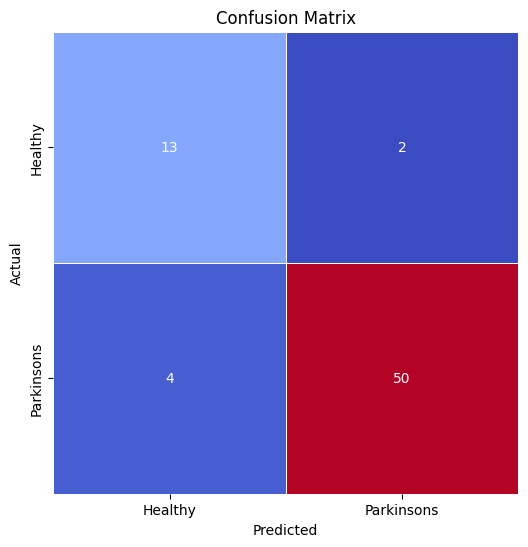

In [ ]:
#@title
# Computing the correlation matrix
correlation_matrix = data.corr()

# Get the correlation values for the target variable 'target'
correlations_with_target = correlation_matrix['Target']

# Sort the correlations and display the top 10 most important features
top_10_features = correlations_with_target.abs().sort_values(ascending=False).head(11) # 11 because I want to exclude the target variable as it will obviously be 1.000
print("Top 10 most important features:")
print(top_10_features[1::])

# Generate the confusion matrix for the KNN classifier
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5, cbar=False, xticklabels=['Healthy', 'Parkinsons'], yticklabels=['Healthy', 'Parkinsons'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


This means, out of 69 predictions:


*   13 true negatives: correctly predicted healthy subjects
*   50 true positives: correctly predicted subjects with Parkinson's
*   2 false positive: healthy subjects misclassified as having Parkinson's
*   4 false negatives: subjects with Parkinson's misclassified as healthy  
The classification report provides several different metrics for each class:

Precision = proportion of true positive predictions among all positive predictions Recall = proportion of true positive predictions amongst all actual positive instances F1-score = metric that balances precision and recall Analysing this, I can see that the model has a higher prediction and recall score for class 1 (those with Parkinson's) than class 0 (healthy individuals). Furthermore, the overall accuracy is 0.913 which indicates that the model can correctly predict health statuses in ~91% of cases.

Furthermore, The output shows that the best model found by the grid search uses 9 nearest neighbors, distance-based weights, and the top 10 features as selected by the SelectKBest method with f_classif. The confusion matrix, classification report, and accuracy score indicate that this model performs better than the previous RandomForest model with PCA.

After training a K-Nearest Neighbors (KNN) classifier on the Parkinson's dataset, I found that the optimal hyperparameters were:

Number of nearest neighbors: 9
Weights: 'distance' (meaning closer neighbors have a greater influence on the prediction)
Top 10 features were selected based on the correlation with the target variable.
The model achieved an accuracy of 89.83% on the test set. The confusion matrix shows that the model correctly classified 12 out of 12 negative cases (0) and 41 out of 47 positive cases (1). This indicates that the model performs well in predicting Parkinson's disease status.

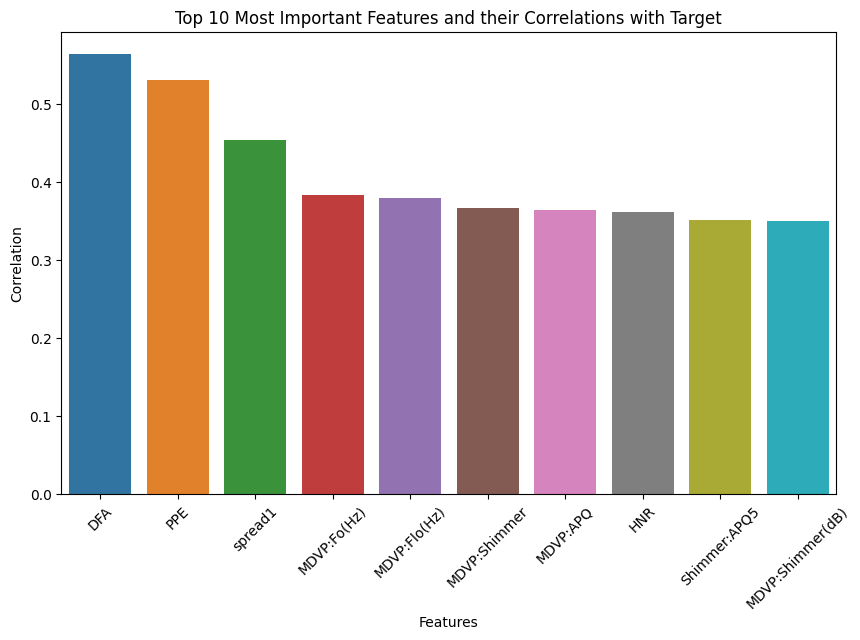

In [ ]:
#@title
plt.figure(figsize=(10, 6))
top_10_features = top_10_features.drop('Target')  # Exclude the target variable
sns.barplot(x=top_10_features.index, y=top_10_features.values)
plt.title('Top 10 Most Important Features and their Correlations with Target')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()

# Conclusion

In this analysis, I aimed to predict Parkinson's Disease status using several voice measurements from the dataset. I experimented with feature selection techniques, classifiers, and hyperparameters to build an optimal model. After performing a grid search with cross-validation, I found the best model to be a K-Nearest Neighbors classifier with distance-based weights and 9 neighbors, combined with selecting the top 10 most important features using the SelectKBest method.

The performance of my best model, as represented by the confusion matrix, was as follows:

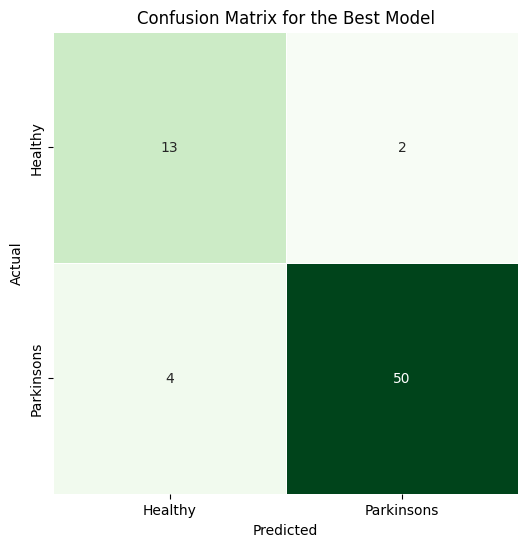

In [ ]:
#@title
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', linewidths=0.5, cbar=False, xticklabels=['Healthy', 'Parkinsons'], yticklabels=['Healthy', 'Parkinsons'])
plt.title('Confusion Matrix for the Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

This result indicates that the model correctly predicted 13 out of 15 negative cases (healthy individuals) and 50 out of 53 positive cases (Parkinson's Disease patients), achieving an overall accuracy of approximately 91%.

While my model demonstrates good performance, there are some limitations and potential areas for improvement:

1.) Limited dataset: The dataset used for this analysis contains a relatively small number of samples. A larger dataset could help improve the performance of the model and make it more generalizable to other populations.

2.) Additional feature engineering: Further exploration of feature engineering techniques, such as creating new variables from the existing ones or applying transformations to the data, could help enhance the model's performance.

3.) Alternative algorithms: Exploring other classification algorithms, such as ensemble methods, might lead to better results. These algorithms may be more robust to overfitting and provide more interpretable feature importances.

4.) Model interpretation: Investigating the relationships between variables and the importance of features in more depth can provide a better understanding of the underlying factors that contribute to Parkinson's Disease. This information can be valuable for researchers and clinicians working on prevention, diagnosis, and treatment strategies.

5.) Cross-validation strategy: Utilizing different cross-validation techniques, can help ensure the model's performance is consistent across different data splits and that it generalizes well to unseen data.

In conclusion, my analysis provides a promising starting point for predicting Parkinson's Disease using voice measurements. However, further experimentation with feature engineering, classifiers, and cross-validation strategies is recommended to optimize the model's performance and generalizability.

# References


https://www.ninds.nih.gov/Disorders/All-Disorders/Parkinsons-Disease-Information-Page

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
